<a href="https://colab.research.google.com/github/itsvismay/Trying-Differentiable-Physics-in-Jax/blob/main/6_Jax_Differentiate_Through_Implicit_Integrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Differentiating Through An Implicit Integrator**
## Task:
Previously, I matched the motion, start pose and stiffness of a larger mass spring systems. In this doc, I will do the same, but update the physics simulator to use implicit integration with larger timesteps. The steps are:


1.  In the simulation function, update explicit verlet with implicit euler.
2.  Requires using a differentiable linear solve
3.  Change energy functions to use flattened coordinates



In [2]:
!pip install meshzoo
%matplotlib inline
import jax
import jax.numpy as jp
import jax.scipy as jscipy
from jax import grad, jit, vmap, jacfwd, jacrev
from jax.lax import scan
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import animation, rc
from IPython.display import HTML
from functools import partial
import meshzoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 4.3 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 99 kB 8.8 MB/s 
     |████████████████████████████████| 856 kB 51.1 MB/s 
     |████████████████████████████████| 4.0 MB 49.9 MB/s 
     |████████████████████████████████| 238 kB 74.9 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 


In [3]:
# rest nodes x,y,z//x,y,z
X0, E = meshzoo.rectangle_tri(
    jp.linspace(0.0, 3.0, 3),
    jp.linspace(5.0, 8.0, 2),
    variant="zigzag",  # or "up", "down", "center"
)
mesh_obj = {"verts": X0, "edges": E}

# rest nodes x,y,z//x,y,z
X0_2 = jp.array(X0.copy())
mesh_obj2 = {"verts": X0_2, "edges": E}

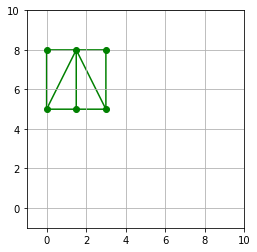

In [83]:
# Plotting tools
def plot(state,  E):
    fig = plt.figure()
    ax = fig.add_subplot(autoscale_on=False, xlim=(-1, 10), ylim=(-1, 10))
    # NOTE: there is no .set_data() for 3 dim data...
    nodes = state#-1 value is inferred
    triang = tri.Triangulation(nodes[:,0], nodes[:,1], triangles=E)
    ax.triplot(triang, 'go-')
    ax.set_aspect('equal')
    ax.grid()
    plt.show()
    
def animate(states1, E):
    fig = plt.figure()
    xlim=(-5, 10)
    ylim=(-10, 10)
    ax = fig.add_subplot(autoscale_on=False, xlim=xlim, ylim=ylim)
    springs1 = ax.triplot(states1[0,:,0], states1[0,:,1], E, 'go-')
    def update(i):
        # # NOTE: there is no .set_data() for 3 dim data...
        ax.cla()
        ax.set(xlim=xlim, ylim=ylim)
        springs1 = ax.triplot(states1[i,:,0], states1[i,:,1], E, 'go-')
        return fig
    anim = animation.FuncAnimation(fig, update, states1.shape[0], interval=20)
    plt.close()
    return anim

def animate_both(states1, states2, E):
    fig = plt.figure()
    xlim=(-5, 10)
    ylim=(-20, 20)
    ax = fig.add_subplot(autoscale_on=False, xlim=xlim, ylim=ylim)
    springs1 = ax.triplot(states1[0,:,0], states1[0,:,1], E, 'go-')
    springs2 = ax.triplot(states2[0,:,0], states2[0,:,1], E, 'bo-')
    def update(i):
        # # NOTE: there is no .set_data() for 3 dim data...
        ax.cla()
        ax.set(xlim=xlim, ylim=ylim)
        springs1 = ax.triplot(states1[i,:,0], states1[i,:,1], E, 'go-')
        springs2 = ax.triplot(states2[i,:,0], states2[i,:,1], E, 'bo-')
        return fig
    anim = animation.FuncAnimation(fig, update, states1.shape[0], interval=20)
    plt.close()
    return anim

plot(X0, E)

**Create** flatten and unflattening functions X -> x

In [171]:
def flatten(X):
  return jp.reshape(X,X.shape[0]*X.shape[1])

def unflatten(x):
  return jp.reshape(x, (-1, 2)) #returns [<any>, 2] sized matrix


**Add masses and inverse Masses** to physics functions

In [195]:
class WorldPhysicsState:
    g : jp.ndarray = jp.array([[0.0,-9.8,0.0]])
    dt: float = 0.1
        
class SpringPhysicsState:
    L0: jp.ndarray
    X0: jp.ndarray
    E: jp.ndarray
    invM: jp.ndarray
    pin: jp.ndarray
    #physics variables
    x: jp.ndarray
    k: jp.ndarray
    v: jp.ndarray
    states: list

def initWorld():
    return WorldPhysicsState()
    
def initSpring(mesh_obj):
    springs = SpringPhysicsState()
    # Physics constants
    springs.X0  = mesh_obj["verts"]
    springs.Elems = mesh_obj["edges"]
    A = [(springs.Elems[i,0], springs.Elems[i,1]) if springs.Elems[i,0] < springs.Elems[i,1] else (springs.Elems[i,1], springs.Elems[i,0]) for i in range(springs.Elems.shape[0])]
    B = [(springs.Elems[i,1], springs.Elems[i,2]) if springs.Elems[i,1] < springs.Elems[i,2] else (springs.Elems[i,2], springs.Elems[i,1]) for i in range(springs.Elems.shape[0])]
    C = [(springs.Elems[i,0], springs.Elems[i,2]) if springs.Elems[i,0] < springs.Elems[i,2] else (springs.Elems[i,2], springs.Elems[i,0]) for i in range(springs.Elems.shape[0])]
    springs.E = jp.array(list(set(A+B+C)))
    springs.L0 = jp.linalg.norm(springs.X0[springs.E[:,1],:] - springs.X0[springs.E[:,0],:], axis=1)
    springs.m = 0.1*jp.ones(springs.X0.shape[0]) # mass per vertex
    springs.invM = jp.kron(jp.diag(1/springs.m), jp.eye(2))

    # Pinned verts indices: TODO: better way to do this (not by hand)
    springs.pin = jp.argwhere(springs.X0[:,1] == jp.max(springs.X0[:,1]))

    # Physics variables
    springs.x = springs.X0.copy()
    springs.k = 1*jp.ones(springs.E.shape[0]) # stiffness per spring (element), TODO: turn into variable
    springs.v = 0*springs.x
    
    return springs

world = initWorld()
spring_target = initSpring(mesh_obj)


**Spring system energy functions** for each spring element as well as gravity potential energy at the verts. For now, each node has a fixed mass.

**Gradients** functions of the energy is also calculated using jax.grad. Additionally an explicit (verlet) **simulation** function records the historical position of the spring at each timestep.

**Introducing Hessians** used in Newton's method. Implicit euler time integration requires solving an optimization problem through Newton's method

In [173]:
def mesh_energy(x, K, X0, Ele, m):
  X = unflatten(x)
  def spring_energy(X,K, X0):
    return 0.5*K*(jp.linalg.norm(X[0,:] - X[1,:])-jp.linalg.norm(X0[0,:] - X0[1,:]))*(jp.linalg.norm(X[0,:] - X[1,:])-jp.linalg.norm(X0[0,:] - X0[1,:]))

  def ele_energy(X, K, X0):
    return spring_energy(X,K,X0)

  def vert_energy(X, m):
      return m*X[1]*9.81
  #Run mesh energy
  s = vmap(ele_energy)(X[Ele,:], K, X0[Ele,:])
  v = vmap(vert_energy)(X, m)
  return jp.sum(s) + jp.sum(v)


grad_fcn = jit(grad(mesh_energy, argnums=0))
hess_fcn = jit(jax.hessian(mesh_energy, argnums=0))

**Define a newton step** and a fixed step size. No line search. Fix each sim step to 5 newton method steps

In [193]:
def simulate(optVar, spring, grad_fcn, hess_fcn, dt, sim_steps):

    #all x, xi, v, are flat
    def newton_step(xi, x0, v0, grad_fcn, hess_fcn, K, X0, E, m, invM, pin, dt):
      H = hess_fcn(xi, K, X0, E, m)
      uf = -unflatten(grad_fcn(xi, K, X0, E, m))
      uf = uf.at[pin].set(0)
      f = flatten(uf)
      g = xi - (x0 + dt*(v0 + dt*(jp.matmul(invM,f))))
      Gradg = jp.identity(g.shape[0]) + dt*dt*(invM*H)
      dxi = -jscipy.linalg.solve(Gradg, g)
      alpha = 0.5 # fixed alpha, no line search
      xi = xi + alpha*dxi
      vi = (xi - x0)/dt
      return xi, vi

    #all x, xi, v, are flat
    def time_step(carry, accum, K, X0, E, m, invM, pin, dt):
      ux0, uv0 = carry
      x0 = flatten(ux0)
      v0 = flatten(uv0)
      xi = flatten(ux0)
      vi = flatten(uv0)

      # Newtons Method: `x_new = x - grad/hess`
      # Solves
      # 0 = g = x_new -(x + dt*(v + dt invM*f) - 0.1v)
      # grad_g = I - dt*dt*invM*H
      for _ in range(3):
        xi, vi = newton_step(xi, x0, v0, grad_fcn, hess_fcn, K, X0, E, m, invM, pin, dt)

      x_new = unflatten(xi)
      v_new = unflatten(vi)
      carry = (x_new, v_new)
      accum = x_new
      return (carry, accum)

    pstep = partial(time_step, 
                    K = optVar[0], 
                    X0= optVar[1], 
                    E = spring.E, 
                    m = spring.m, 
                    invM= spring.invM,
                    pin=spring.pin, 
                    dt = dt)

    carry = (optVar[1], spring.v)
    outputs = []
    carry, outputs = scan(pstep, 
                          carry, 
                          xs=None, 
                          length=sim_steps)
    
    return outputs

**Create** a New Spring (Green) and simulate both the target(blue) and new springs. Animate both for 200 steps and notice the differences.

In [194]:
spring_target_states = simulate((spring_target.k, spring_target.X0), spring_target, grad_fcn, hess_fcn, world.dt, 200)
# HTML(animate(spring_target_states, spring_target.E).to_html5_video())
#create new spring
spring_current = initSpring(mesh_obj2)
# change up its stiffness
spring_current.k = 0.2*spring_current.k

initial_states = simulate((spring_current.k, spring_current.X0), spring_current, grad_fcn, hess_fcn, world.dt, 200)
HTML(animate_both(initial_states, spring_target_states, spring_target.Elems).to_html5_video())

[1 4 2 4 4 3 4 5 5]


**Create the physics loss** function and its gradient which takes the norm between the target spring and the spring being optimized.

In [197]:
@jit
def simulation_match_loss(opt_var, target_states):
    states = simulate(opt_var, spring_current, grad_fcn, hess_fcn, world.dt, 200)
    #loss = the difference at each timestep between target states and current states
    loss = jp.linalg.norm(target_states - states)
    return loss

grad_simulation_match_loss = grad(simulation_match_loss, argnums=0)

**Optimize over the physics simulation loss** with gradient descent. Todo: use jax.grad_with_value instead of jax.grad

In [198]:
ov_k, ov_X0 = spring_current.k,spring_current.X0
optVars = (ov_k, ov_X0)
#Crappy gradient descent with fixed step size
for _ in range(100):
    dk,dX0 = grad_simulation_match_loss(optVars, spring_target_states)
    dX0 = dX0.at[spring_current.pin].set(0)
    ov_k = ov_k - dk*0.05
    ov_X0 = ov_X0 - dX0*0.05
    optVars = ov_k, ov_X0
    print("loss: "+str(simulation_match_loss(optVars, spring_target_states)))


loss: 90.18943
loss: 83.30617
loss: 76.959885
loss: 71.23621
loss: 66.21434
loss: 61.95225
loss: 58.470573
loss: 55.741238
loss: 53.687958
loss: 52.200584
loss: 51.156967
loss: 50.44262
loss: 49.962257
loss: 49.643066
loss: 49.4325
loss: 49.294167
loss: 49.203403
loss: 49.14388
loss: 49.10478
loss: 49.07906
loss: 49.06206
loss: 49.050804
loss: 49.04332
loss: 49.03831
loss: 49.034954
loss: 49.032658
loss: 49.031105
loss: 49.03001
loss: 49.029274
loss: 49.02877
loss: 49.028416
loss: 49.028145
loss: 49.02798
loss: 49.027813
loss: 49.027725
loss: 49.027664
loss: 49.0276
loss: 49.02755
loss: 49.02752
loss: 49.027496
loss: 49.027485
loss: 49.02747
loss: 49.027462
loss: 49.02745
loss: 49.027443
loss: 49.02744
loss: 49.02744
loss: 49.02744
loss: 49.02743
loss: 49.02743
loss: 49.027428
loss: 49.027424
loss: 49.027424
loss: 49.02742
loss: 49.02742
loss: 49.027416
loss: 49.027416
loss: 49.027416
loss: 49.02742
loss: 49.027416
loss: 49.027416
loss: 49.027416
loss: 49.027416
loss: 49.027416
loss: 4

**Animate** the final optimized state of the spring system and overlay with the target simulation

In [182]:
states = simulate(optVars, spring_current, grad_fcn, hess_fcn, world.dt, 200)
anim2 = animate_both(states, spring_target_states, spring_target.Elems)
HTML(anim2.to_html5_video())

Check out the values of the optimization variables.

## Next Steps

1.   Baraf Witkin cloth energy
3.   Try to use other loss functions. Maybe look at forces/velocity rather than just position
4.   Use ADAM or something with a LS step for the optimization. 

